# Seminar QF: Credit Risk Analysis Pipeline

This notebook implements a comprehensive pipeline for credit risk analysis using various volatility models:
1.  **Merton Model**: To estimate asset values and volatility from equity data.
2.  **GARCH(1,1)**: Single-regime volatility modeling.
3.  **Regime-Switching (Hamilton Filter)**: Volatility modeling with regime changes.
4.  **MS-GARCH**: Optimized Markov-Switching GARCH model.
5.  **Monte Carlo Simulation**: To forecast future asset values.
6.  **CDS Spread Calculation**: Estimating credit default swap spreads based on simulated default probabilities.

### 0. Setup
Initialize the environment, add `src` to the system path, and define configuration.

In [1]:
# Setup
import sys
import os
import shutil
from pathlib import Path
import pandas as pd
import numpy as np

# Add project root to path so we can import src
# Assuming notebook is in notebooks/, project root is parent
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import config and modules
try:
    from src.utils import config
    from src.data.data_processing import load_and_preprocess_data, run_merton_estimation, load_interest_rates
    from src.models.garch_model import run_garch_estimation
    from src.models.regime_switching import run_regime_switching_estimation
    from src.models.ms_garch_optimized import run_ms_garch_estimation_optimized
    from src.models.probability_of_default import run_pd_pipeline, calculate_merton_pd_normal
    from src.analysis.result_summary import generate_results_summary
    from src.analysis.monte_carlo_garch import monte_carlo_garch_1year_parallel  # Use parallel version
    from src.analysis.volatility_diagnostics import run_volatility_diagnostics, filter_problematic_firms
    from src.analysis.monte_carlo_regime_switching import monte_carlo_regime_switching_1year_parallel  # Use parallel version
    from src.analysis.monte_carlo_ms_garch import monte_carlo_ms_garch_1year_parallel  # Use parallel version
    from src.analysis.monte_carlo_merton import monte_carlo_merton_1year_parallel  # NEW: Merton MC
    from src.analysis.cds_spread_calculator import CDSSpreadCalculator
    from src.analysis.cds_correlation import run_cds_correlation_analysis, plot_cds_correlations

    print("Imports successful.")
    print(f"Data Directory: {config.DATA_DIR}")
except ImportError as e:
    print(f"Import Error: {e}")
    # print(f"sys.path: {sys.path}")

Imports successful.
Data Directory: /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data


### 1. Cache Cleanup
Remove intermediate files.

In [2]:
# Cache Cleanup
print("Cleaning up cache files...")
cache_dir = config.INTERMEDIATES_DIR
cache_files = [
    'merton_results_cache.pkl',
    'mc_garch_cache.csv'
]

for cache_file in cache_files:
    cache_path = cache_dir / cache_file
    if cache_path.exists():
        try:
            os.remove(cache_path)
            print(f"✓ Deleted: {cache_path}")
        except Exception as e:
            print(f"⚠ Could not delete {cache_path}: {e}")
    else:
        print(f"  (No cached file: {cache_path})")

print("Cache cleanup complete.")


Cleaning up cache files...
✓ Deleted: /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/intermediates/merton_results_cache.pkl
  (No cached file: /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/intermediates/mc_garch_cache.csv)
Cache cleanup complete.


### 2. Data Loading & Merton Model Estimation
*   **Load Interest Rates**: From ECB data.
*   **Load Equity Data**: From Excel inputs.
*   **Run Merton Model**: Solves for Asset Value ($V_t$) and Asset Volatility ($\sigma_A$) using the iterative approach.
*   **Output**: `merged_data_with_merton.csv` and `daily_asset_returns.csv`.

In [3]:
# Load Interest Rates
interest_rates_df = load_interest_rates()
print(f"Loaded {len(interest_rates_df)} months of interest rate data")

# Load Equity/Liability Data
df = load_and_preprocess_data()

# Run Merton Model
df_merged, daily_returns_df = run_merton_estimation(df, interest_rates_df)

# Save Results
df_merged.to_csv(config.OUTPUT_DIR / "merged_data_with_merton.csv", index=False)
daily_returns_df.to_csv(config.OUTPUT_DIR / "daily_asset_returns.csv", index=False)

print(f"Saved to {config.OUTPUT_DIR}")

Loaded 384 months of interest rate data
Loading equity data...
Removed 16 flagged companies (data quality issues)
Remaining firms: 34

Filtered out 8602 rows from 2025 (keeping data up to and including 2024)
Loading liability data...
Scaled liabilities from millions to actual currency units (×1,000,000)
Removed 16 flagged companies (data quality issues)
Remaining firms: 34

Filtered out 8602 rows from 2025 (keeping data up to and including 2024)
Loading liability data...
Scaled liabilities from millions to actual currency units (×1,000,000)
Merging liabilities using Point-in-Time (fdate) logic (backward-looking)...
Loaded liability data

MERTON MODEL ESTIMATION (Vectorized + Parallelized - EXACT ndtr)

Processing 34 firms with -1 parallel jobs...

Starting parallel Merton estimation...
Merging liabilities using Point-in-Time (fdate) logic (backward-looking)...
Loaded liability data

MERTON MODEL ESTIMATION (Vectorized + Parallelized - EXACT ndtr)

Processing 34 firms with -1 parallel j

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  Firm 1/34 (gvkey=14447): 200/3912 dates
  Firm 4/34 (gvkey=15617): 200/3912 dates
  Firm 6/34 (gvkey=15724): 200/3912 dates
  Firm 5/34 (gvkey=15677): 200/3912 dates
  Firm 2/34 (gvkey=15532): 200/3912 dates
  Firm 8/34 (gvkey=17436): 200/3912 dates
  Firm 3/34 (gvkey=15549): 200/3912 dates
  Firm 7/34 (gvkey=16348): 200/3912 dates
  Firm 1/34 (gvkey=14447): 300/3912 dates
  Firm 4/34 (gvkey=15617): 300/3912 dates
  Firm 5/34 (gvkey=15677): 300/3912 dates
  Firm 8/34 (gvkey=17436): 300/3912 dates
  Firm 6/34 (gvkey=15724): 300/3912 dates
  Firm 2/34 (gvkey=15532): 300/3912 dates
  Firm 1/34 (gvkey=14447): 300/3912 dates
  Firm 4/34 (gvkey=15617): 300/3912 dates
  Firm 5/34 (gvkey=15677): 300/3912 dates
  Firm 8/34 (gvkey=17436): 300/3912 dates
  Firm 6/34 (gvkey=15724): 300/3912 dates
  Firm 2/34 (gvkey=15532): 300/3912 dates
  Firm 3/34 (gvkey=15549): 300/3912 dates
  Firm 1/34 (gvkey=14447): 400/3912 dates
  Firm 7/34 (gvkey=16348): 300/3912 dates
  Firm 4/34 (gvkey=15617): 400/391

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.0s


  Firm 6/34 (gvkey=15724): 3500/3912 dates
  Firm 5/34 (gvkey=15677): 3500/3912 dates
  Firm 9/34 (gvkey=17452): 400/3912 dates
  Firm 7/34 (gvkey=16348): 3200/3912 dates
  Firm 10/34 (gvkey=19349): 200/3912 dates
  Firm 2/34 (gvkey=15532): 3700/3912 dates
  Firm 6/34 (gvkey=15724): 3600/3912 dates
  Firm 4/34 (gvkey=15617): 3500/3912 dates
  Firm 7/34 (gvkey=16348): 3200/3912 dates
  Firm 10/34 (gvkey=19349): 200/3912 dates
  Firm 2/34 (gvkey=15532): 3700/3912 dates
  Firm 6/34 (gvkey=15724): 3600/3912 dates
  Firm 4/34 (gvkey=15617): 3500/3912 dates
  Firm 5/34 (gvkey=15677): 3600/3912 dates
  Firm 9/34 (gvkey=17452): 500/3912 dates
  Firm 5/34 (gvkey=15677): 3600/3912 dates
  Firm 9/34 (gvkey=17452): 500/3912 dates
  Firm 7/34 (gvkey=16348): 3300/3912 dates
  Firm 10/34 (gvkey=19349): 300/3912 dates
  Firm 2/34 (gvkey=15532): 3800/3912 dates
  Firm 6/34 (gvkey=15724): 3700/3912 dates
  Firm 9/34 (gvkey=17452): 600/3912 dates
  Firm 7/34 (gvkey=16348): 3300/3912 dates
  Firm 10/34 (g

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.5s


  Firm 11/34 (gvkey=23667): 3200/3912 dates
  Firm 14/34 (gvkey=61616): 2800/3912 dates
  Firm 10/34 (gvkey=19349): 3500/3912 dates
  Firm 13/34 (gvkey=24625): 2900/3912 dates
  Firm 15/34 (gvkey=63120): 2100/3912 dates
  Firm 12/34 (gvkey=23671): 2800/3912 dates
  Firm 16/34 (gvkey=100022): 200/3912 dates
  Firm 11/34 (gvkey=23667): 3300/3912 dates
  Firm 17/34 (gvkey=100080): 200/3912 dates
  Firm 10/34 (gvkey=19349): 3600/3912 dates
  Firm 13/34 (gvkey=24625): 3000/3912 dates
  Firm 15/34 (gvkey=63120): 2100/3912 dates
  Firm 12/34 (gvkey=23671): 2800/3912 dates
  Firm 16/34 (gvkey=100022): 200/3912 dates
  Firm 11/34 (gvkey=23667): 3300/3912 dates
  Firm 17/34 (gvkey=100080): 200/3912 dates
  Firm 10/34 (gvkey=19349): 3600/3912 dates
  Firm 13/34 (gvkey=24625): 3000/3912 dates
  Firm 14/34 (gvkey=61616): 2900/3912 dates
  Firm 17/34 (gvkey=100080): 300/3912 dates
  Firm 15/34 (gvkey=63120): 2200/3912 dates
  Firm 14/34 (gvkey=61616): 2900/3912 dates
  Firm 17/34 (gvkey=100080): 300

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   49.2s


  Firm 22/34 (gvkey=101336): 2800/3912 dates
  Firm 16/34 (gvkey=100022): 3700/3912 dates
  Firm 23/34 (gvkey=101361): 2000/3912 dates
  Firm 20/34 (gvkey=101202): 3200/3912 dates
  Firm 21/34 (gvkey=101204): 3100/3912 dates
  Firm 19/34 (gvkey=100957): 3300/3912 dates
  Firm 22/34 (gvkey=101336): 2900/3912 dates
  Firm 20/34 (gvkey=101202): 3200/3912 dates
  Firm 21/34 (gvkey=101204): 3100/3912 dates
  Firm 19/34 (gvkey=100957): 3300/3912 dates
  Firm 22/34 (gvkey=101336): 2900/3912 dates
  Firm 24/34 (gvkey=102296): 200/3912 dates
  Firm 16/34 (gvkey=100022): 3800/3912 dates
  Firm 25/34 (gvkey=103487): 200/3912 dates
  Firm 23/34 (gvkey=101361): 2100/3912 dates
  Firm 20/34 (gvkey=101202): 3300/3912 dates
  Firm 24/34 (gvkey=102296): 200/3912 dates
  Firm 16/34 (gvkey=100022): 3800/3912 dates
  Firm 25/34 (gvkey=103487): 200/3912 dates
  Firm 23/34 (gvkey=101361): 2100/3912 dates
  Firm 20/34 (gvkey=101202): 3300/3912 dates
  Firm 21/34 (gvkey=101204): 3200/3912 dates
  Firm 22/34 (

[Parallel(n_jobs=-1)]: Done  23 out of  34 | elapsed:   56.7s remaining:   27.1s


  Firm 24/34 (gvkey=102296): 1800/3912 dates
  Firm 27/34 (gvkey=201794): 1100/3912 dates
  Firm 25/34 (gvkey=103487): 2100/3912 dates
  Firm 29/34 (gvkey=220940): 1100/3912 dates
  Firm 26/34 (gvkey=132740): 1800/3912 dates
  Firm 28/34 (gvkey=220833): 1100/3912 dates
  Firm 30/34 (gvkey=221244): 1000/3912 dates
  Firm 24/34 (gvkey=102296): 1900/3912 dates
  Firm 29/34 (gvkey=220940): 1100/3912 dates
  Firm 26/34 (gvkey=132740): 1800/3912 dates
  Firm 28/34 (gvkey=220833): 1100/3912 dates
  Firm 30/34 (gvkey=221244): 1000/3912 dates
  Firm 24/34 (gvkey=102296): 1900/3912 dates
  Firm 27/34 (gvkey=201794): 1200/3912 dates
  Firm 31/34 (gvkey=221616): 200/3912 dates
  Firm 25/34 (gvkey=103487): 2200/3912 dates
  Firm 27/34 (gvkey=201794): 1200/3912 dates
  Firm 31/34 (gvkey=221616): 200/3912 dates
  Firm 25/34 (gvkey=103487): 2200/3912 dates
  Firm 26/34 (gvkey=132740): 1900/3912 dates
  Firm 29/34 (gvkey=220940): 1200/3912 dates
  Firm 30/34 (gvkey=221244): 1100/3912 dates
  Firm 28/34

[Parallel(n_jobs=-1)]: Done  27 out of  34 | elapsed:  1.2min remaining:   18.3s


  Firm 27/34 (gvkey=201794): 3800/3912 dates
  Firm 31/34 (gvkey=221616): 2900/3912 dates
  Firm 34/34 (gvkey=241637): 800/3912 dates
  Firm 29/34 (gvkey=220940): 3900/3912 dates
  Firm 32/34 (gvkey=222379): 1300/3912 dates
  Firm 33/34 (gvkey=241456): 900/3912 dates
  Firm 28/34 (gvkey=220833): 3700/3912 dates
  Firm 27/34 (gvkey=201794): 3900/3912 dates
  Firm 34/34 (gvkey=241637): 900/3912 dates
  Firm 31/34 (gvkey=221616): 3000/3912 dates
  Firm 32/34 (gvkey=222379): 1400/3912 dates
  Firm 33/34 (gvkey=241456): 1000/3912 dates
  Firm 28/34 (gvkey=220833): 3800/3912 dates
  Firm 27/34 (gvkey=201794): 3900/3912 dates
  Firm 34/34 (gvkey=241637): 900/3912 dates
  Firm 31/34 (gvkey=221616): 3000/3912 dates
  Firm 32/34 (gvkey=222379): 1400/3912 dates
  Firm 33/34 (gvkey=241456): 1000/3912 dates
  Firm 28/34 (gvkey=220833): 3800/3912 dates
  Firm 34/34 (gvkey=241637): 1000/3912 dates
  Firm 31/34 (gvkey=221616): 3100/3912 dates
  Firm 32/34 (gvkey=222379): 1500/3912 dates
  Firm 33/34 (

[Parallel(n_jobs=-1)]: Done  31 out of  34 | elapsed:  1.2min remaining:    7.1s


  Firm 32/34 (gvkey=222379): 2400/3912 dates
  Firm 33/34 (gvkey=241456): 2000/3912 dates
  Firm 34/34 (gvkey=241637): 2000/3912 dates
  Firm 32/34 (gvkey=222379): 2500/3912 dates
  Firm 33/34 (gvkey=241456): 2100/3912 dates
  Firm 34/34 (gvkey=241637): 2100/3912 dates
  Firm 32/34 (gvkey=222379): 2600/3912 dates
  Firm 33/34 (gvkey=241456): 2200/3912 dates
  Firm 33/34 (gvkey=241456): 2100/3912 dates
  Firm 34/34 (gvkey=241637): 2100/3912 dates
  Firm 32/34 (gvkey=222379): 2600/3912 dates
  Firm 33/34 (gvkey=241456): 2200/3912 dates
  Firm 34/34 (gvkey=241637): 2200/3912 dates
  Firm 32/34 (gvkey=222379): 2700/3912 dates
  Firm 33/34 (gvkey=241456): 2300/3912 dates
  Firm 34/34 (gvkey=241637): 2300/3912 dates
  Firm 32/34 (gvkey=222379): 2800/3912 dates
  Firm 34/34 (gvkey=241637): 2200/3912 dates
  Firm 32/34 (gvkey=222379): 2700/3912 dates
  Firm 33/34 (gvkey=241456): 2300/3912 dates
  Firm 34/34 (gvkey=241637): 2300/3912 dates
  Firm 32/34 (gvkey=222379): 2800/3912 dates
  Firm 33/

[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:  1.3min finished



✓ Parallel Merton complete in 0:01:18

Caching 127,942 Merton results...
✓ Cached to: /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/intermediates/merton_results_cache.pkl

Merton Estimation Complete
Total time: 0:01:18
Firms processed: 34
Daily results: 127,908

Saved to /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output
Saved to /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output


### 3. GARCH(1,1) Estimation
Estimates a standard GARCH(1,1) model on the daily asset returns derived from the Merton model.
*   **Input**: `daily_asset_returns.csv`
*   **Output**: `daily_asset_returns_with_garch.csv` (adds conditional volatility columns).

In [4]:
final_daily_returns = run_garch_estimation(daily_returns_df)

# Save Results
final_daily_returns.to_csv(config.OUTPUT_DIR / "daily_asset_returns_with_garch.csv", index=False)
print("Saved 'daily_asset_returns_with_garch.csv'")

Estimating GARCH(1,1) with t-distribution on DAILY Asset Returns...
Processing GARCH for 34 firms (Daily Data)...
Processed GARCH for 10 firms...
Processed GARCH for 10 firms...
Processed GARCH for 20 firms...
Processed GARCH for 20 firms...
Processed GARCH for 30 firms...
Processed GARCH for 30 firms...
GARCH estimation complete.

✓ Saved GARCH parameters to '/Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/garch_parameters.csv'
  Successfully estimated 34 firms
  Mean persistence (α+β): 0.9358
  Mean degrees of freedom (ν): 3.73
GARCH estimation complete.

✓ Saved GARCH parameters to '/Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/garch_parameters.csv'
  Successfully estimated 34 firms
  Mean persistence (α+β): 0.9358
  Mean degrees of freedom (ν): 3.73
Saved 'daily_asset_returns_with_garch.csv'
Saved 'daily_asset_returns_with_garch.csv'


### 4. Regime-Switching Model (Hamilton Filter)
Estimates a 2-state Markov Switching model on returns (High Volatility / Low Volatility states), independent of GARCH dynamics inside the states.
*   **Output**: `daily_asset_returns_with_regime.csv`.

In [5]:
final_daily_returns_rs = run_regime_switching_estimation(daily_returns_df)

# Save Results
final_daily_returns_rs.to_csv(config.OUTPUT_DIR / "daily_asset_returns_with_regime.csv", index=False)
print("Saved 'daily_asset_returns_with_regime.csv'")

Estimating Regime Switching Model (2-Regime Markov) on DAILY Returns...
(Hamilton Filter)

Processing Regime Switching for 34 firms...

  ✓ Firm 1/34: gvkey=14447
      Observations: 3762
      Regime 0 (HIGH vol/stress): μ=0.000004, σ=0.018540
      Regime 1 (LOW vol/calm): μ=0.000755, σ=0.007952
      Transition: P(0→0)=0.839, P(1→1)=0.908

  ✓ Firm 1/34: gvkey=14447
      Observations: 3762
      Regime 0 (HIGH vol/stress): μ=0.000004, σ=0.018540
      Regime 1 (LOW vol/calm): μ=0.000755, σ=0.007952
      Transition: P(0→0)=0.839, P(1→1)=0.908

  ✓ Firm 2/34: gvkey=15532
      Observations: 3762
      Regime 0 (HIGH vol/stress): μ=0.001709, σ=0.228783
      Regime 1 (LOW vol/calm): μ=0.000390, σ=0.002504
      Transition: P(0→0)=0.598, P(1→1)=0.908

  ✓ Firm 2/34: gvkey=15532
      Observations: 3762
      Regime 0 (HIGH vol/stress): μ=0.001709, σ=0.228783
      Regime 1 (LOW vol/calm): μ=0.000390, σ=0.002504
      Transition: P(0→0)=0.598, P(1→1)=0.908

  ✓ Firm 3/34: gvkey=15549
 

### 5. Optimized MS-GARCH Estimation
Estimates a "True" MS-GARCH model where each regime has its own GARCH(1,1) process.
*   **Optimizations**: Uses Warm Start, JIT Compilation (Numba), and Numerical Optimizations.
*   **Output**: `daily_asset_returns_with_msgarch.csv` and parameter file.

In [6]:
print("Running MS-GARCH Estimation...")
final_daily_returns_msgarch = run_ms_garch_estimation_optimized(
    daily_returns_df,
    output_file=str(config.OUTPUT_DIR / "ms_garch_parameters.csv")
)

# Save Results
final_daily_returns_msgarch.to_csv(config.OUTPUT_DIR / "daily_asset_returns_with_msgarch.csv", index=False)
print("Saved 'daily_asset_returns_with_msgarch.csv'")

Running MS-GARCH Estimation...

OPTIMIZED MS-GARCH ESTIMATION
Optimizations enabled:
  ✓ GARCH(1,1) warm start for initial parameters
  ✓ Numba JIT-compiled Hamilton filter
  ✓ Cached intermediate results
  ✓ L-BFGS-B optimizer with tuned settings

Processing 34 firms...

[1/34] Processing 14447
  Fitting OPTIMIZED MS-GARCH with t-distribution...
    → Getting GARCH(1,1) warm start parameters...
    → Warm start: omega=2.01e-02, alpha=0.043, beta=0.947, nu=4.5
    → Initial degrees of freedom: ν₀=12.0 (low-vol), ν₁=2.5 (high-vol)
    → Running IMPROVED optimization with multi-start and adaptive refinement...
    → PHASE 1: Multi-start optimization (3 different initializations)...
      → Trying Base initialization...
        ✓ New best: -LL = 5931.56
      → Trying Extreme initialization...
        ✓ New best: -LL = 5931.56
      → Trying Extreme initialization...
      → Trying Moderate initialization...
      → Trying Moderate initialization...
    → PHASE 1 complete: Best initializa

### 6. Probability of Default (PD) Calculation
Calculates PD using the Merton Model formula but substituting the volatility estimates from GARCH, RS, and MS-GARCH models.
*   **Benchmark**: Calculates standard Merton PD assuming Normal distribution.
*   **Output**: `daily_pd_results.csv`.

In [7]:
pd_results = run_pd_pipeline(
    str(config.OUTPUT_DIR / 'daily_asset_returns_with_garch.csv'), 
    str(config.OUTPUT_DIR / 'daily_asset_returns_with_regime.csv'), 
    str(config.OUTPUT_DIR / 'daily_asset_returns_with_msgarch.csv')
)

pd_results.to_csv(config.OUTPUT_DIR / "daily_pd_results.csv", index=False)
print("Saved 'daily_pd_results.csv'")

# Merton PD (Benchmark)
merton_normal_pd = calculate_merton_pd_normal(str(config.OUTPUT_DIR / 'daily_asset_returns.csv'))
merton_normal_pd.to_csv(config.OUTPUT_DIR / "daily_pd_results_merton_normal.csv", index=False)
print("Saved 'daily_pd_results_merton_normal.csv'")


PROBABILITY OF DEFAULT CALCULATION (Multi-Model, Daily Data)
Loading auxiliary data (liabilities and interest rates)...
  Loading liabilities...
    ✓ Loaded 741 liability records (scaled from millions to full units)
  Loading interest rates...
    ✓ Loaded 384 months of interest rate data

Calculating PD for each model...

  Processing GARCH...
    ✓ Loaded 741 liability records (scaled from millions to full units)
  Loading interest rates...
    ✓ Loaded 384 months of interest rate data

Calculating PD for each model...

  Processing GARCH...
    ✓ GARCH: Calculated PD for 127,908 observations
       PD column name: 'pd_garch'

  Processing Regime Switching...
    ✓ GARCH: Calculated PD for 127,908 observations
       PD column name: 'pd_garch'

  Processing Regime Switching...
    ✓ Loaded regime parameters from regime_switching_parameters.csv
    ✓ Loaded regime parameters from regime_switching_parameters.csv
    ✓ Computed regime-weighted volatility for 127,908 observations
    ✓

### 7. Monte Carlo Simulation (GARCH) & Diagnostics
Simulates future asset values for 1 year (252 days) using GARCH volatility dynamics.
Also runs **Volatility Diagnostics** to identify firms with explosive volatility that might distort results.
*   **Output**: `daily_monte_carlo_garch_results.csv` and diagnostic files in `data/diagnostics/`.

In [ ]:
print("Run Monte Carlo GARCH (1 year) - PARALLEL with all cores...")
mc_results = monte_carlo_garch_1year_parallel(
    str(config.OUTPUT_DIR / 'daily_asset_returns_with_garch.csv'), 
    gvkey_selected=None, 
    num_simulations=10000,
    num_days=252,
    n_jobs=-1  # Use all available cores
)
mc_results.to_csv(config.OUTPUT_DIR / "daily_monte_carlo_garch_results.csv", index=False)

# Diagnostics
print("Running Volatility Diagnostics...")
diagnostics_results = run_volatility_diagnostics(
    garch_file=str(config.OUTPUT_DIR / 'daily_asset_returns_with_garch.csv'),
    mc_garch_file=str(config.OUTPUT_DIR / 'daily_monte_carlo_garch_results.csv'),
    output_dir=str(config.DIAGNOSTICS_DIR)
)

PROBLEMATIC_FIRMS = diagnostics_results['problematic_firms']
CLEAN_FIRMS = diagnostics_results['clean_firms']
print(f"Problematic Firms: {len(PROBLEMATIC_FIRMS)}")

Run Monte Carlo GARCH (1 year) - PARALLEL with all cores...
Loading GARCH data from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/daily_asset_returns_with_garch.csv...
Running PARALLELIZED Monte Carlo GARCH simulation:
  Firms: 34
  Dates: 3762
  Simulations per firm: 1,000
  Forecast horizon: 252 days
  Parallel jobs: -1
  Innovation distribution: Student's t
Running PARALLELIZED Monte Carlo GARCH simulation:
  Firms: 34
  Dates: 3762
  Simulations per firm: 1,000
  Forecast horizon: 252 days
  Parallel jobs: -1
  Innovation distribution: Student's t

Processing 3762 dates in parallel...

Processing 3762 dates in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   


PARALLELIZED MONTE CARLO GARCH COMPLETE
Total time: 0:31:38
Rows per second: 67
Speedup: ~-1x expected on -1-core system

Running Volatility Diagnostics...

VOLATILITY DIAGNOSTICS: IDENTIFYING PROBLEMATIC FIRMS

Running Volatility Diagnostics...

VOLATILITY DIAGNOSTICS: IDENTIFYING PROBLEMATIC FIRMS

✓ Loaded GARCH data: 127,908 observations
✓ Number of firms: 34

------------------------------------------------------------
PART 1: GARCH PARAMETER ANALYSIS
------------------------------------------------------------


------------------------------------------------------------
PART 2: MONTE CARLO VOLATILITY ANALYSIS
------------------------------------------------------------

✓ Loaded GARCH data: 127,908 observations
✓ Number of firms: 34

------------------------------------------------------------
PART 1: GARCH PARAMETER ANALYSIS
------------------------------------------------------------


------------------------------------------------------------
PART 2: MONTE CARLO VOLATILIT

### 8. Monte Carlo Simulation (Regime Switching & MS-GARCH)
Runs MC simulations for the Regime-Switching and MS-GARCH models.
*   **Regime Switching**: Simulates regime changes and draws returns based on state-specific volatility (no GARCH).
*   **MS-GARCH**: Simulates regime changes AND GARCH dynamics within each state.

In [ ]:
print("Run MC Regime Switching - PARALLEL with all cores...")
mc_rs_results = monte_carlo_regime_switching_1year_parallel(
    garch_file=str(config.OUTPUT_DIR / 'daily_asset_returns_with_garch.csv'),
    regime_params_file=str(config.OUTPUT_DIR / 'regime_switching_parameters.csv'),
    gvkey_selected=None,
    num_simulations=10000,
    num_days=252,
    n_jobs=-1  # Use all available cores
)
mc_rs_results.to_csv(config.OUTPUT_DIR / "daily_monte_carlo_regime_switching_results.csv", index=False)

Run MC Regime Switching - PARALLEL with all cores...

PARALLELIZED MONTE CARLO REGIME-SWITCHING 1-YEAR FORECAST

✓ Loaded regime-switching parameters for 34 firms
✓ Loaded 127,908 observations
  Firms: 34
  Dates: 3762
  Simulations: 1,000
  Horizon: 252 days
  Parallel jobs: -1
✓ Loaded 127,908 observations
  Firms: 34
  Dates: 3762
  Simulations: 1,000
  Horizon: 252 days
  Parallel jobs: -1

Processing 3762 dates in parallel...

Processing 3762 dates in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   


PARALLELIZED REGIME-SWITCHING MC COMPLETE
Total rows: 127,908
Total time: 0:10:31
Rows per second: 203



In [ ]:
print("Run MC MS-GARCH - PARALLEL with all cores...")
mc_msgarch_results = monte_carlo_ms_garch_1year_parallel(
    daily_returns_file=str(config.OUTPUT_DIR / 'daily_asset_returns_with_msgarch.csv'),
    ms_garch_params_file=str(config.OUTPUT_DIR / 'ms_garch_parameters.csv'),
    gvkey_selected=None,
    num_simulations=10000,
    num_days=252,
    n_jobs=-1  # Use all available cores
)
mc_msgarch_results.to_csv(config.OUTPUT_DIR / "daily_monte_carlo_ms_garch_results.csv", index=False)

Run MC MS-GARCH - PARALLEL with all cores...
Loading daily returns from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/daily_asset_returns_with_msgarch.csv...
Loading MS-GARCH parameters from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/ms_garch_parameters.csv...
Running PARALLELIZED Monte Carlo MS-GARCH simulation:
  Firms: 34
  Dates: 3762
  Simulations per firm: 1,000
  Forecast horizon: 252 days
  Parallel jobs: -1
  Innovation distribution: Student's t per regime
Loading MS-GARCH parameters from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/ms_garch_parameters.csv...
Running PARALLELIZED Monte Carlo MS-GARCH simulation:
  Firms: 34
  Dates: 3762
  Simulations per firm: 1,000
  Forecast horizon: 252 days
  Parallel jobs: -1
  Innovation distribution: Student's t per regime

Processing 3762 dates in parallel...

Processing 3762 dates in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1


Regime Fraction Statistics:
  Regime 0 (low vol): mean=0.600
  Regime 1 (high vol): mean=0.400

PARALLELIZED MONTE CARLO MS-GARCH COMPLETE
Total time: 0:52:03
Rows per second: 41
Speedup: ~-1x expected on -1-core system



### 8D. Monte Carlo Simulation - Merton (Constant Volatility Baseline)
Run Monte Carlo simulation using constant volatility from Merton model for fair comparison.
- Uses the same Monte Carlo framework as other models
- Constant volatility (σ_daily) from Merton estimation
- Provides baseline to measure improvement from time-varying volatility models

In [ ]:
print("Running Merton Monte Carlo (Constant Volatility) - PARALLEL...")
mc_merton_results = monte_carlo_merton_1year_parallel(
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    num_simulations=10000,
    num_days=252,
    n_jobs=-1  # Use all available cores
)
mc_merton_results.to_csv(config.OUTPUT_DIR / "daily_monte_carlo_merton_results.csv", index=False)
print(f"✓ Merton MC completed: {len(mc_merton_results)} rows saved")

Running Merton Monte Carlo (Constant Volatility) - PARALLEL...

MONTE CARLO: MERTON CONSTANT VOLATILITY (1-Year Forecast)

Loading Merton estimation results...
Dropped 5,066 rows with missing asset_volatility

Dataset summary:
  Firms: 34
  Dates: 3763
  Total observations: 127,942

Monte Carlo settings:
  Simulations per firm-date: 1000
  Forecast horizon: 252 days (1 year)
  Parallel jobs: All cores

Starting simulation...

Dropped 5,066 rows with missing asset_volatility

Dataset summary:
  Firms: 34
  Dates: 3763
  Total observations: 127,942

Monte Carlo settings:
  Simulations per firm-date: 1000
  Forecast horizon: 252 days (1 year)
  Parallel jobs: All cores

Starting simulation...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  


MONTE CARLO MERTON COMPLETE

Results summary:
  Total observations: 127,942
  Unique firms: 34
  Date range: 2010-07-30 00:00:00 to 2024-12-31 00:00:00

Annualized Volatility Statistics:
  Mean: 0.1368 (13.68%)
  Median: 0.1194
  Min: 0.0061
  Max: 11.8863
  (Should match original Merton asset_volatility)

Integrated Variance Statistics:
  Mean: 0.0499
  Median: 0.0142
  Min: 0.0000
  Max: 141.2850

Performance:
  Total time: 0:05:56
  Observations per second: 358

✓ Verification passed: Output volatility matches input (max diff: 0.000000)

✓ Merton MC completed: 127942 rows saved
✓ Merton MC completed: 127942 rows saved


### 9. CDS Spread Calculation
Calculates Model-Implied CDS Spreads for 1, 3, and 5-year horizons.

**Models:**
1. **Classical Merton (Analytical)**: Uses the asset volatility from the Merton model estimation directly (no Monte Carlo).
2. **Merton MC (Baseline)**: Uses Monte Carlo simulation with constant volatility for fair comparison.
3. **GARCH**: Uses Monte Carlo simulated volatility from GARCH(1,1) model.
4. **Regime Switching**: Uses Monte Carlo simulated volatility from the Hamilton Filter RS model.
5. **MS-GARCH**: Uses Monte Carlo simulated volatility from the Markov-Switching GARCH model.

**Output:** Separate CSV files for CDS spreads for each model.

In [12]:
# Reload the CDS spread calculator module to pick up latest changes
import importlib
from src.analysis import cds_spread_calculator
importlib.reload(cds_spread_calculator)
from src.analysis.cds_spread_calculator import CDSSpreadCalculator

print("✓ CDS Spread Calculator module reloaded")

# Initialize with 25% recovery rate (default)
cds_calc = CDSSpreadCalculator(maturity_horizons=[1, 3, 5], recovery_rate=0.25)

✓ CDS Spread Calculator module reloaded

CDS Spread Calculator initialized (Section 2.4.2):
  CDS Maturities: [1, 3, 5] years
  Recovery Rate: 25% (Loss Given Default: 75%)
  Methodology: Malone et al. (2009) - Risk-neutral valuation



In [13]:
# Classical Merton (Analytical - no Monte Carlo, uses asset_volatility from Merton estimation)
print("CDS Spreads: Classical Merton (Analytical)")
df_cds_spreads_merton = cds_calc.calculate_cds_spreads_analytical_merton(
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    output_file=str(config.OUTPUT_DIR / 'cds_spreads_merton_analytical.csv')
)

# Merton MC (Constant Volatility Baseline)
print("CDS Spreads: Merton MC (Constant Volatility)")
df_cds_spreads_merton_mc = cds_calc.calculate_cds_spreads_from_mc_garch(
    mc_garch_file=str(config.OUTPUT_DIR / 'daily_monte_carlo_merton_results.csv'),
    daily_returns_file=str(config.OUTPUT_DIR / 'daily_asset_returns.csv'),
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    output_file=str(config.OUTPUT_DIR / 'cds_spreads_merton_mc_all_firms.csv'),
    model_name='Merton_MC'
)

# GARCH
print("CDS Spreads: GARCH")
df_cds_spreads_garch_all = cds_calc.calculate_cds_spreads_from_mc_garch(
    mc_garch_file=str(config.OUTPUT_DIR / 'daily_monte_carlo_garch_results.csv'),
    daily_returns_file=str(config.OUTPUT_DIR / 'daily_asset_returns.csv'),
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    output_file=str(config.OUTPUT_DIR / 'cds_spreads_garch_mc_all_firms.csv'),
    model_name='GARCH'
)

# Regime Switching
print("CDS Spreads: RS")
df_cds_spreads_rs_all = cds_calc.calculate_cds_spreads_from_mc_garch(
    mc_garch_file=str(config.OUTPUT_DIR / 'daily_monte_carlo_regime_switching_results.csv'),
    daily_returns_file=str(config.OUTPUT_DIR / 'daily_asset_returns.csv'),
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    output_file=str(config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv'),
    model_name='Regime Switching'
)

# MS-GARCH
print("CDS Spreads: MS-GARCH")
df_cds_spreads_msgarch_all = cds_calc.calculate_cds_spreads_from_mc_garch(
    mc_garch_file=str(config.OUTPUT_DIR / 'daily_monte_carlo_ms_garch_results.csv'),
    daily_returns_file=str(config.OUTPUT_DIR / 'daily_asset_returns.csv'),
    merton_file=str(config.OUTPUT_DIR / 'merged_data_with_merton.csv'),
    output_file=str(config.OUTPUT_DIR / 'cds_spreads_ms_garch_mc_all_firms.csv'),
    model_name='MS-GARCH'
)

CDS Spreads: Classical Merton (Analytical)

ANALYTICAL MERTON CDS SPREADS

Loading Merton results from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/merged_data_with_merton.csv...
Filtered 5066 rows with missing values.
Loading Interest Rates...
Filtered 5066 rows with missing values.
Loading Interest Rates...
Merging Interest Rates...
Calculating CDS Spreads (Analytical Merton)...
Saving results to /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_merton_analytical.csv...
Merging Interest Rates...
Calculating CDS Spreads (Analytical Merton)...
Saving results to /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_merton_analytical.csv...
Done calculation.

CDS Spreads: Merton MC (Constant Volatility)

MODEL-IMPLIED CDS SPREADS FROM MONTE CARLO (Section 2.4.2)

Loading data files...

✓ Loaded Monte Carlo results: 127,942 observations
  Columns: ['gvkey', 'date', 'merton_mc_integrated_variance', 'merton_mc_annualized_

### 10. Model vs Market CDS Spread Correlation
Compare model-implied CDS spreads with actual market CDS data.
- Loads real CDS data (in basis points) for 1Y, 3Y, and 5Y maturities.
- Matches companies between model and market data.
- Calculates correlations for each firm and overall.

Running CDS Correlation Analysis...
Loading real CDS market data...
  Loaded CDS data: 1Y=166960, 3Y=166960, 5Y=154438 rows
  Loaded CDS data: 1Y=166960, 3Y=166960, 5Y=154438 rows
  Combined market CDS data: 200352 rows
  Combined market CDS data: 200352 rows

=== Classical Merton Model vs Market CDS ===
  Matched observations: 127942
  Matched companies: 34

  RMSE (Market - Model, in bps):
    1Y: 1291.80 bps (n=110170)
    3Y: 440.89 bps (n=112689)
    5Y: 297.75 bps (n=127010)

  Correlation of LEVELS:
    1Y: 0.2246 (n=110170)
    3Y: 0.1744 (n=112689)
    5Y: 0.2927 (n=127010)

  Correlation of CHANGES (Innovations) - Byström (2006):
    1Y: 0.0194 (n=110140)
    3Y: 0.0230 (n=112658)
    5Y: 0.0383 (n=126976)

=== Classical Merton Model vs Market CDS ===
  Matched observations: 127942
  Matched companies: 34

  RMSE (Market - Model, in bps):
    1Y: 1291.80 bps (n=110170)
    3Y: 440.89 bps (n=112689)
    5Y: 297.75 bps (n=127010)

  Correlation of LEVELS:
    1Y: 0.2246 (n=1101

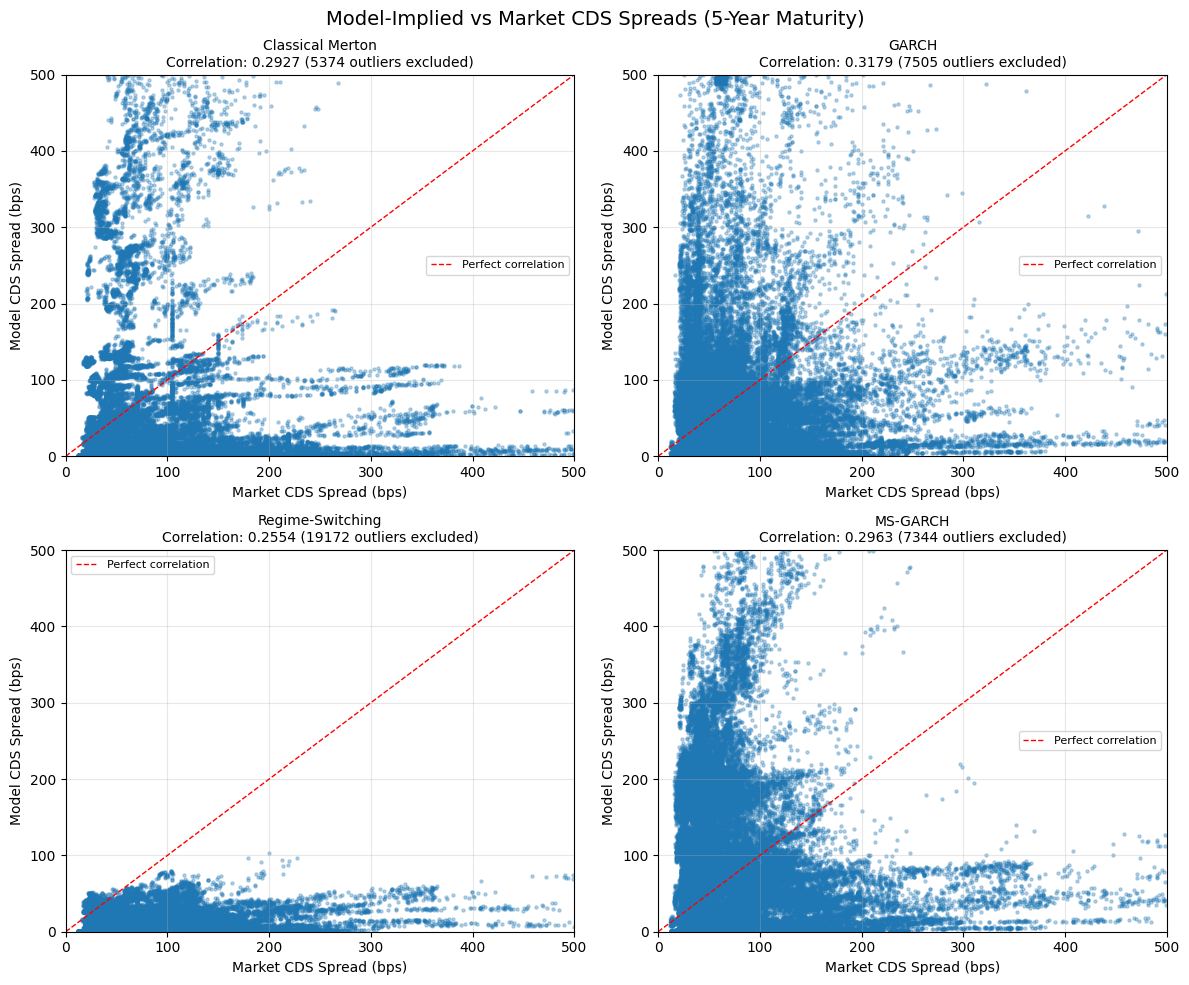

Saved scatter plot to /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_model_vs_market_scatter_5y.png


In [14]:
# Reload the module to pick up changes
import importlib
from src.analysis import cds_correlation
importlib.reload(cds_correlation)
from src.analysis.cds_correlation import run_cds_correlation_analysis, plot_cds_correlations

# Run CDS Correlation Analysis
print("Running CDS Correlation Analysis...")
correlation_results = run_cds_correlation_analysis()

# Plot scatter plots (5-year maturity)
# Use axis_limit=500 to zoom in on reasonable CDS spread ranges and exclude extreme outliers
# This makes the visualization clearer without affecting correlation calculations
plot_cds_correlations(correlation_results, maturity=5, axis_limit=500)